# <b>CS156 (Introduction to AI), Spring 2021</b>
# <u><b>Assignment_11</b></u>

### Roster Name: GURSIMRAN SINGH
### Preferred Name (if different): SIMRAN
### Student ID: 015212210
### Email address: gursimransingh@sjsu.edu


### Implementing GAN model to generate fashion Images


# solution

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from numpy.random import randn
from numpy import vstack
from numpy import asarray

In [ ]:
(x_train_valid, y_train_valid), (x_test, y_test)=keras.datasets.fashion_mnist.load_data()
print(x_train_valid[0][15])

4423680/4422102 [==============================] - 0s 0us/step
[  0   3   0   0   0   0   0   0   0  62 145 204 228 207 213 221 218 208
 211 218 224 223 219 215 224 244 159   0]


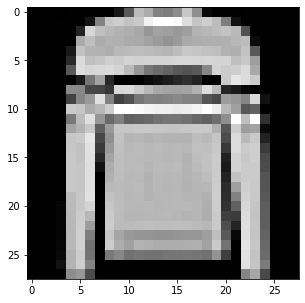

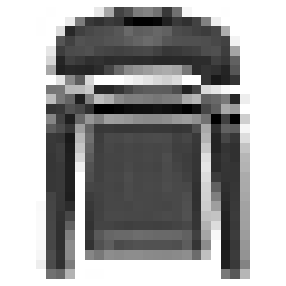

In [ ]:
plt.figure(figsize=(5, 5))
#ax = plt.subplot()
plt.imshow(x_train_valid[5].reshape(28, 28))
plt.gray()
x_test.shape,x_train_valid.shape


# plot reverse gray scale:
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(x_train_valid[5].reshape(28, 28), cmap='gray_r')
plt.show()

# concatenationg the data

In [ ]:
data= np.concatenate([x_train_valid,x_test],axis=0)
data = expand_dims(data, axis=-1)
values= np.concatenate((y_train_valid,y_test),axis=0)

In [ ]:
data.shape,values.shape

((70000, 28, 28, 1), (70000,))

In [ ]:
#shape images to 0 to 1
# Scale images to the [0, 1] range
data = data.astype("float32") / 255

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape)) # When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers, does not include the sample axis),
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4)) #droupout is a regularization technique where randomly selected neurons are ignored during training.
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (5,5), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the discriminator model
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          1

# Generator

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (1,1), strides=(1,1), padding='same')) 
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model
 
# size of the latent space
latent_dim = 100
# define the discriminator model
generator = define_generator(latent_dim)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       16512     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 128)      

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

gan_model = define_gan(generator, discriminator)
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         1180801   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 143169    
Total params: 1,323,970
Trainable params: 1,180,801
Non-trainable params: 143,169
_________________________________________________________________


### Without training the GAN our model will produce very bad images

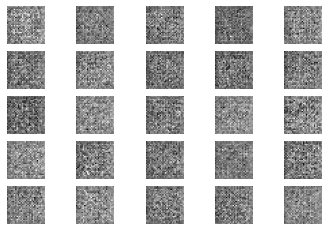

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_generator_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

# generate samples
n_samples = 25
X, _ = generate_fake_generator_samples(generator, latent_dim, n_samples)
for i in range(n_samples):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(X[i, :, :, 0], cmap='gray_r')

plt.show()

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
       
# train the generator and discriminator together
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d_loss=%.3f, g_loss=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    summarize_performance(i, g_model, d_model, dataset, latent_dim)
            
    return g_model

In [ ]:
# size of the latent space
latent_dim = 100
# train model
trained_generator = train(generator, discriminator, gan_model, data, latent_dim, 10)

>1, 1/273, d_loss=0.698, g_loss=0.731
>1, 2/273, d_loss=0.687, g_loss=0.746
>1, 3/273, d_loss=0.680, g_loss=0.759
>1, 4/273, d_loss=0.676, g_loss=0.765
>1, 5/273, d_loss=0.668, g_loss=0.772
>1, 6/273, d_loss=0.664, g_loss=0.780
>1, 7/273, d_loss=0.650, g_loss=0.800
>1, 8/273, d_loss=0.640, g_loss=0.802
>1, 9/273, d_loss=0.630, g_loss=0.804
>1, 10/273, d_loss=0.618, g_loss=0.804
>1, 11/273, d_loss=0.599, g_loss=0.795
>1, 12/273, d_loss=0.589, g_loss=0.776
>1, 13/273, d_loss=0.574, g_loss=0.753
>1, 14/273, d_loss=0.548, g_loss=0.745
>1, 15/273, d_loss=0.541, g_loss=0.731
>1, 16/273, d_loss=0.526, g_loss=0.722
>1, 17/273, d_loss=0.516, g_loss=0.746
>1, 18/273, d_loss=0.496, g_loss=0.848
>1, 19/273, d_loss=0.482, g_loss=0.916
>1, 20/273, d_loss=0.459, g_loss=0.955
>1, 21/273, d_loss=0.476, g_loss=0.895
>1, 22/273, d_loss=0.461, g_loss=0.811
>1, 23/273, d_loss=0.450, g_loss=0.755
>1, 24/273, d_loss=0.460, g_loss=0.715
>1, 25/273, d_loss=0.466, g_loss=0.681
>1, 26/273, d_loss=0.460, g_loss=0

# Plotting after 10 epochs

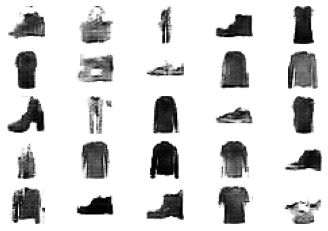

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# create and display a plot of generated images (reversed grayscale)
def display_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

latent_points = generate_latent_points(100, 25)
X = trained_generator.predict(latent_points)
# plot the result
display_plot(X, 5)

In [ ]:
# size of the latent space
latent_dim = 100
# train model
trained_generator = train(generator, discriminator, gan_model, data, latent_dim, 100)

Streaming output truncated to the last 5000 lines.
>82, 189/273, d_loss=0.686, g_loss=0.761
>82, 190/273, d_loss=0.682, g_loss=0.761
>82, 191/273, d_loss=0.685, g_loss=0.738
>82, 192/273, d_loss=0.677, g_loss=0.746
>82, 193/273, d_loss=0.684, g_loss=0.714
>82, 194/273, d_loss=0.688, g_loss=0.696
>82, 195/273, d_loss=0.682, g_loss=0.683
>82, 196/273, d_loss=0.680, g_loss=0.683
>82, 197/273, d_loss=0.689, g_loss=0.694
>82, 198/273, d_loss=0.691, g_loss=0.696
>82, 199/273, d_loss=0.685, g_loss=0.705
>82, 200/273, d_loss=0.700, g_loss=0.741
>82, 201/273, d_loss=0.682, g_loss=0.751
>82, 202/273, d_loss=0.690, g_loss=0.761
>82, 203/273, d_loss=0.691, g_loss=0.746
>82, 204/273, d_loss=0.695, g_loss=0.717
>82, 205/273, d_loss=0.684, g_loss=0.721
>82, 206/273, d_loss=0.668, g_loss=0.694
>82, 207/273, d_loss=0.677, g_loss=0.699
>82, 208/273, d_loss=0.697, g_loss=0.725
>82, 209/273, d_loss=0.692, g_loss=0.757
>82, 210/273, d_loss=0.698, g_loss=0.764
>82, 211/273, d_loss=0.678, g_loss=0.769
>82, 2

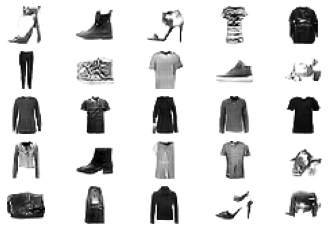

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# create and display a plot of generated images (reversed grayscale)
def display_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

latent_points = generate_latent_points(100, 25)
# generate images
X = trained_generator.predict(latent_points)
# plot the result
display_plot(X, 5)